In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
import matplotlib.pyplot as plt
from IPython.display import display
import shap
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances
from clustering import make_clustering
from tasks.running_example import make_task
shap.initjs()

In [2]:
feature_precisions = [1, 1]

In [3]:
clf_a, clf_b, X, y, feature_names = make_task()

In [4]:
xlim = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
ylim = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

In [5]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [6]:
# Do not sample from background data set but use all available instances
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])

In [7]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='indiv', space_type='labels')
with open('indiv.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 4.23 s, sys: 70.8 ms, total: 4.3 s
Wall time: 4.35 s


In [9]:
%%time
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='mclass_diff', space_type='labels')
with open('diffclf.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 482 ms, sys: 6.68 ms, total: 489 ms
Wall time: 496 ms


# Traditional SHAP Explanations

In [10]:
with open('indiv.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [11]:
# For binary classification problems only the positive class is interesting
indiv_shap_values = indiv_shap_values[:, :, ['A.1', 'B.1']]

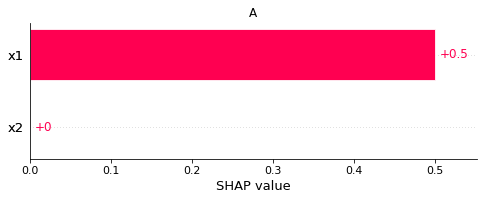

In [12]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'A.1'])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

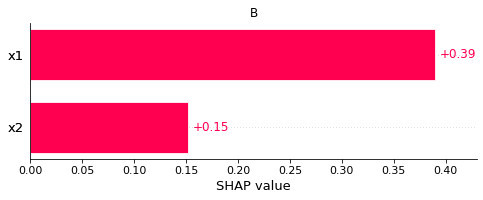

In [13]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'B.1'])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [14]:
%%time
node = make_clustering(comparer, indiv_shap_values, feature_precisions=feature_precisions)

CPU times: user 17.5 ms, sys: 2.21 ms, total: 19.7 ms
Wall time: 21.7 ms


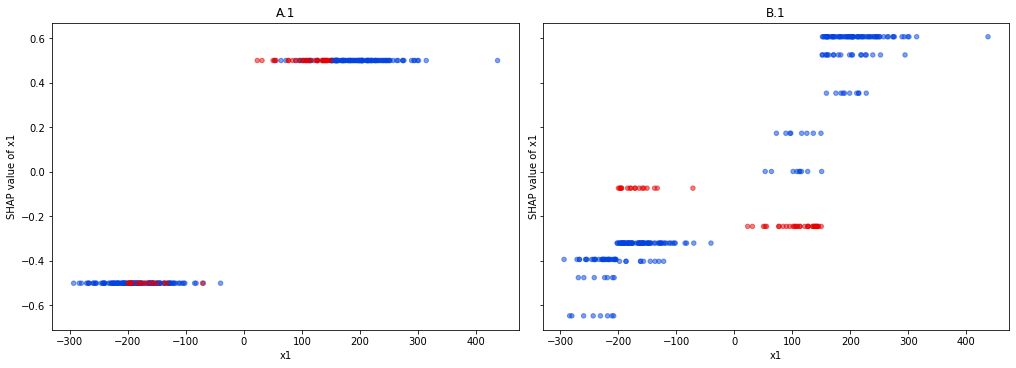

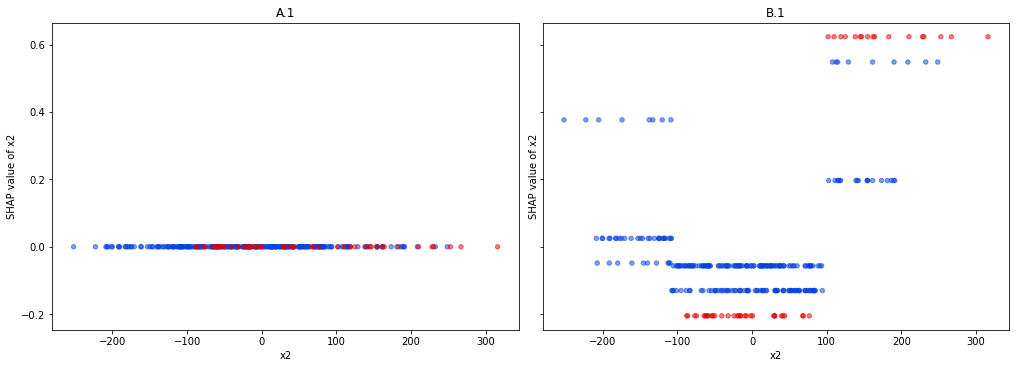

In [15]:
for feature in feature_names:
    node.plot_feature_dependence(feature, alpha=0.5)

# Difference Classifier SHAP Explanations

In [16]:
with open('diffclf.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

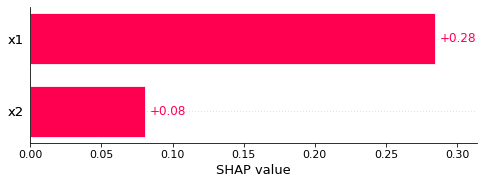

In [17]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

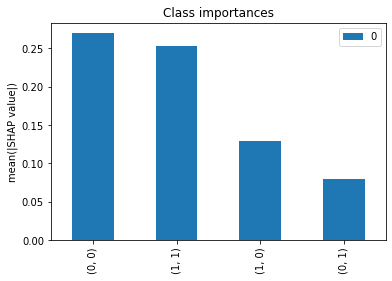

In [18]:
class_order, class_importances = calc_class_order(diffclf_shap_values)
plot_class_importances(class_importances, class_order, diffclf_shap_values.output_names)

## Clustering of Class $(0,1)$ SHAP Values

In [19]:
%%time
node = make_clustering(comparer, diffclf_shap_values,
                       '(0, 1)', ['(0, 0)', '(0, 1)', '(1, 1)'],
                       feature_precisions=feature_precisions)
node.class_counts, node.distance

CPU times: user 1.3 s, sys: 12.9 ms, total: 1.31 s
Wall time: 1.33 s


((0, 0)    133
 (1, 1)    118
 (1, 0)     32
 (0, 1)     17
 dtype: int64,
 2.637883333333333)

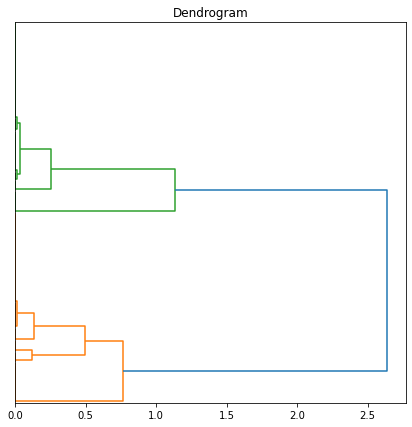

In [20]:
node.plot_dendrogram()

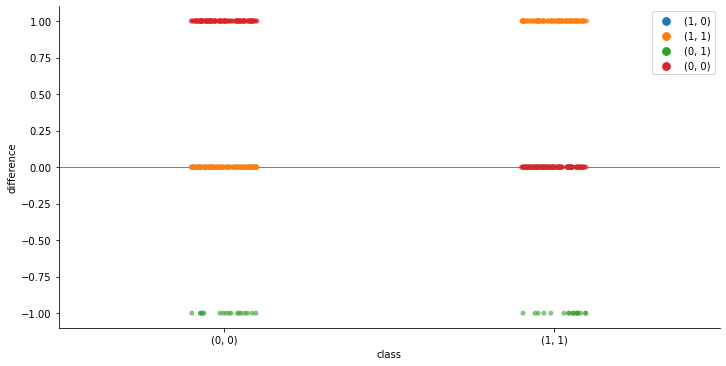

{'(0, 0)': '-1.0 to -1.0', '(1, 1)': '-1.0 to -1.0'}


In [21]:
node.plot_outcome_differences()

### Node RL

In [22]:
node = node.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RL,
 (0, 1)    17
 dtype: int64,
 0.0)

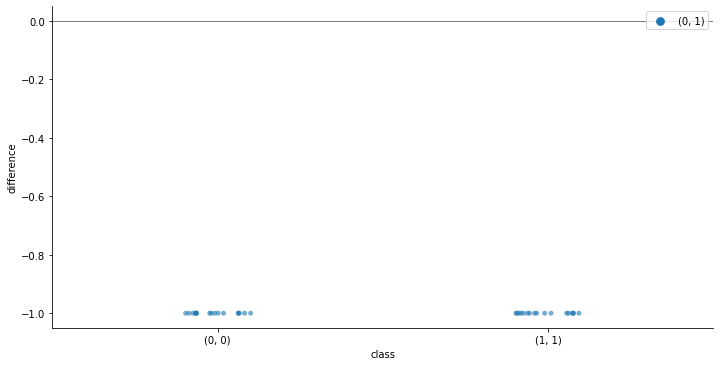

{'(0, 0)': '-1.0 to -1.0', '(1, 1)': '-1.0 to -1.0'}


In [23]:
node.plot_outcome_differences()

We've certainly reached the lowest layer, because the distance is 0.

-199.69916519629095 <= x1 <= -71.25341441967325
x1 <= -203.8 --> {'(0, 0)': 17}
x1 >= -8.5 --> {'(1, 1)': 17}


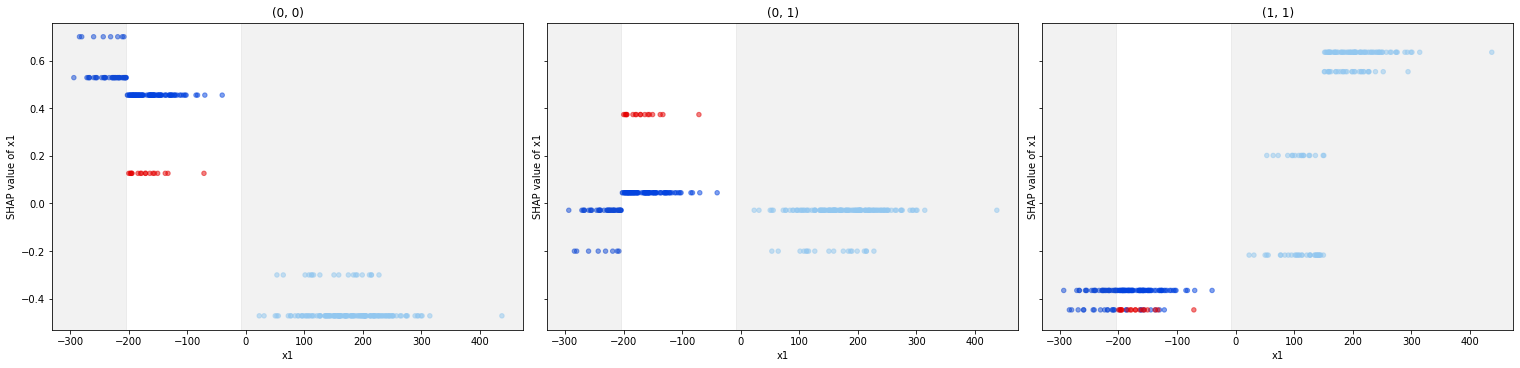

101.87170468931079 <= x2
x2 <= 97.5 --> {'(0, 0)': 17}


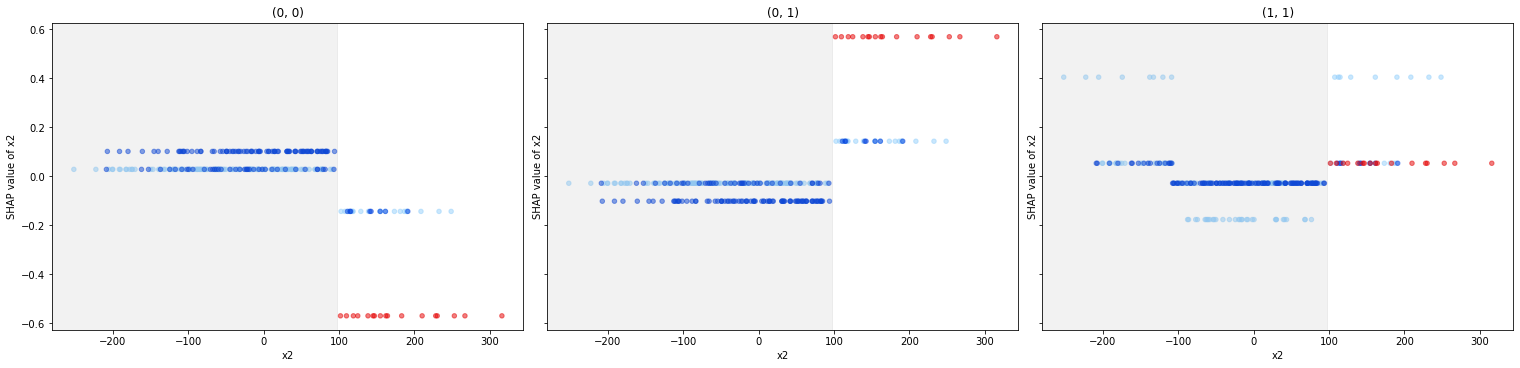

In [24]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node.parent, alpha=0.5)

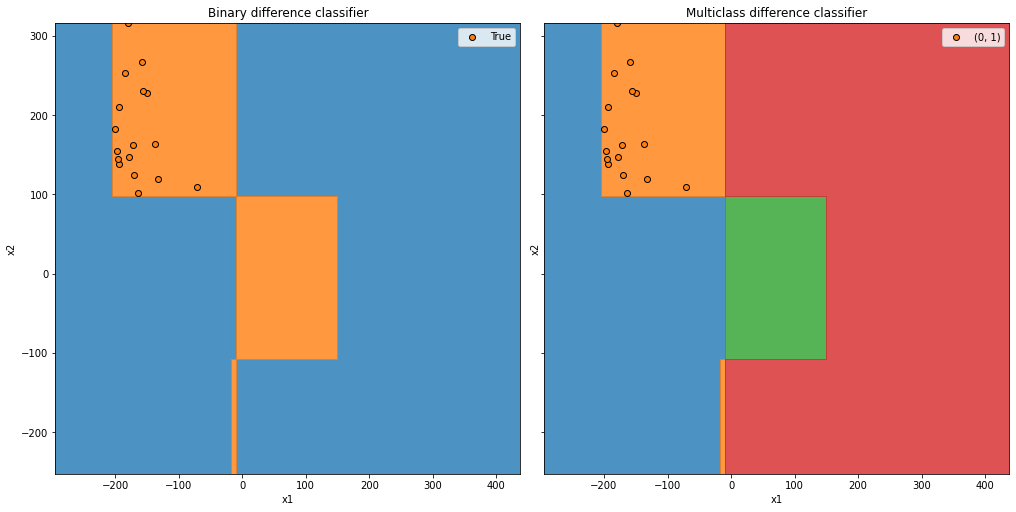

In [25]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

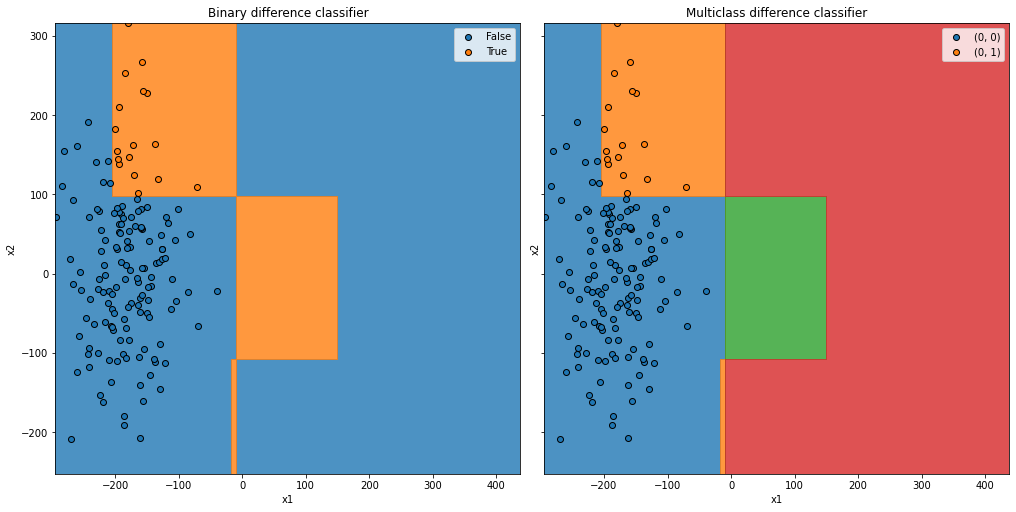

In [26]:
comparer.plot_decision_boundaries(node.parent.shap_values.data, xlim=xlim, ylim=ylim)

## Clustering of Class $(1,0)$ SHAP Values

In [27]:
%%time
node = make_clustering(comparer, diffclf_shap_values,
                       '(1, 0)', ['(0, 0)', '(1, 0)', '(1, 1)'],
                       feature_precisions=feature_precisions)
node.class_counts, node.distance

CPU times: user 1.4 s, sys: 17.4 ms, total: 1.42 s
Wall time: 1.47 s


((0, 0)    133
 (1, 1)    118
 (1, 0)     32
 (0, 1)     17
 dtype: int64,
 2.5922833333333326)

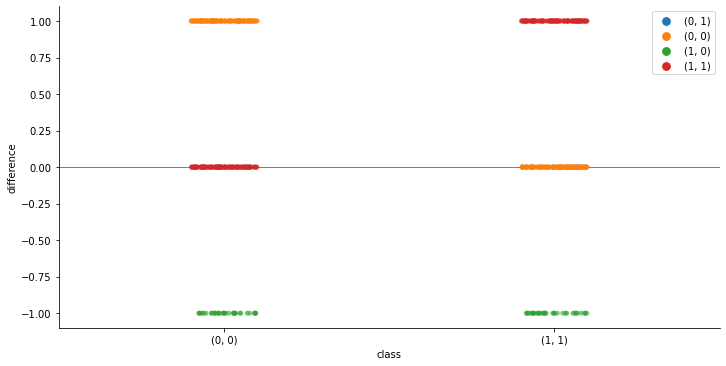

{'(0, 0)': '-1.0 to -1.0', '(1, 1)': '-1.0 to -1.0'}


In [28]:
node.plot_outcome_differences()

### Node RL

In [29]:
node = node.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RL,
 (1, 0)    32
 dtype: int64,
 0.0)

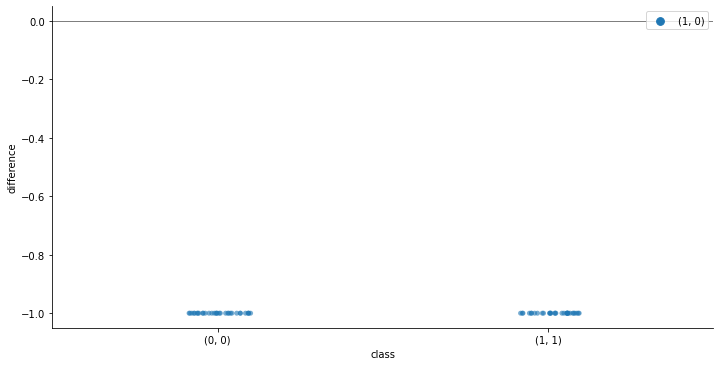

{'(0, 0)': '-1.0 to -1.0', '(1, 1)': '-1.0 to -1.0'}


In [30]:
node.plot_outcome_differences()

23.067264476014415 <= x1 <= 149.93548780588142
x1 <= -8.6 --> {'(0, 0)': 32}
x1 >= 150.8 --> {'(1, 1)': 32}


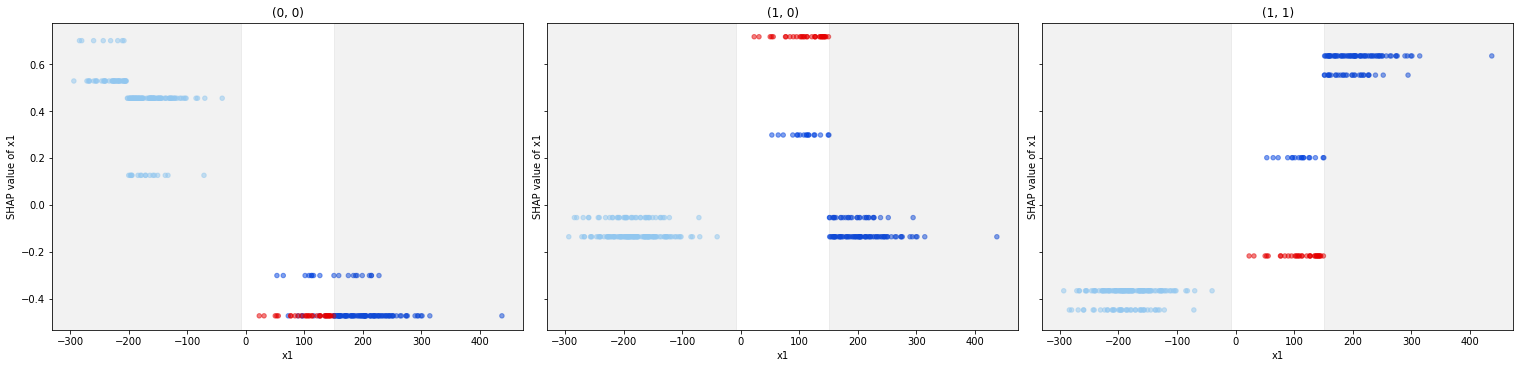

-87.58963700149516 <= x2 <= 76.76250825051287
x2 <= -108.2 --> {'(1, 1)': 32}
x2 >= 97.6 --> {'(1, 1)': 32}


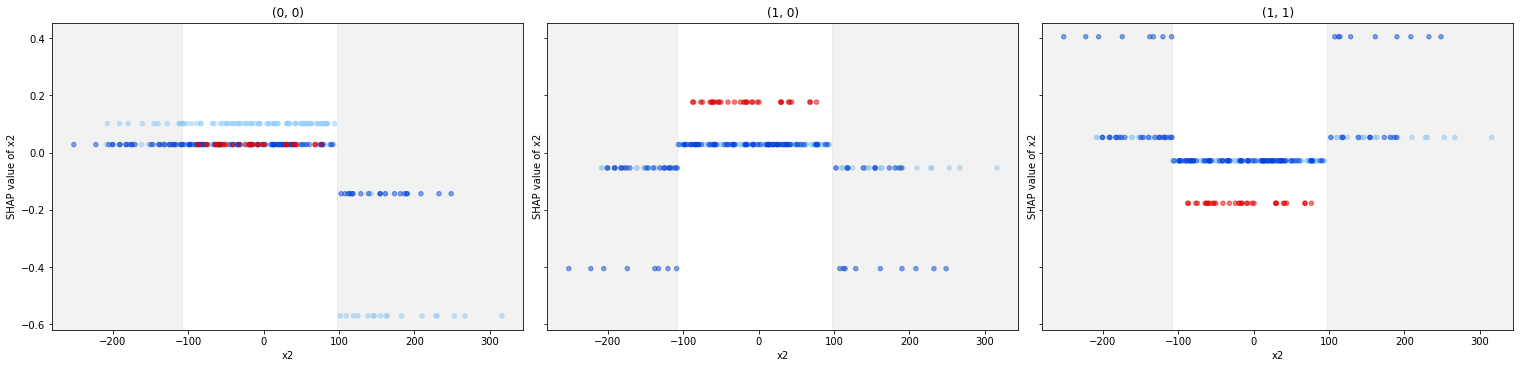

In [31]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node.parent, alpha=0.5)

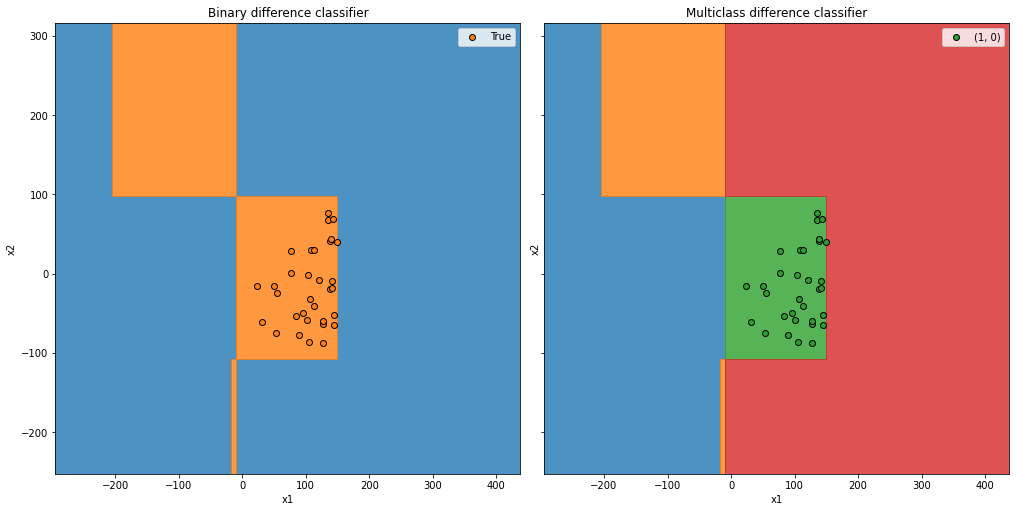

In [32]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

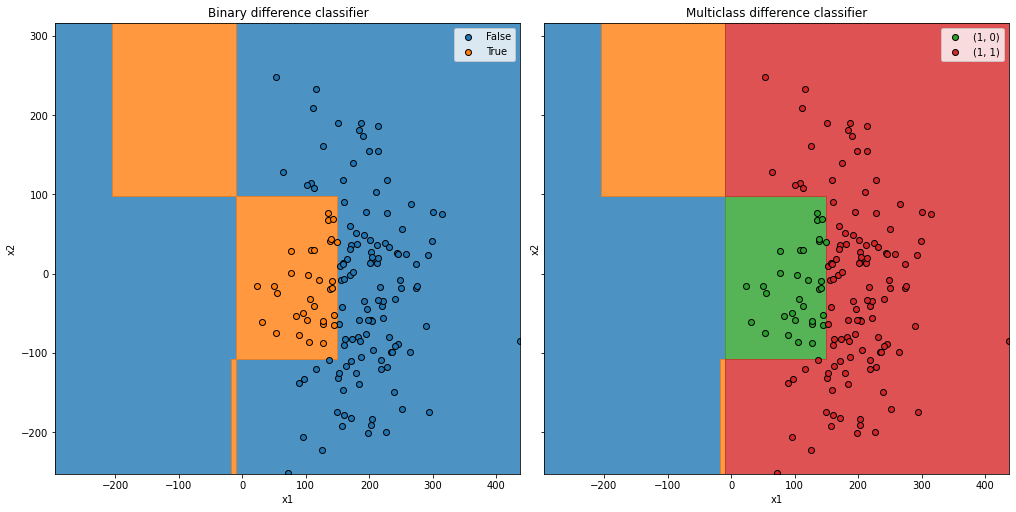

In [33]:
comparer.plot_decision_boundaries(node.parent.shap_values.data, xlim=xlim, ylim=ylim)

# Explanations
- rule 1 ($(0,1)$/node RL): $-203.8 < x1 < -8.5, 97.5 < x2 \rightarrow (0,1)$
- rule 2 ($(1,0)$/node RL): $-8.6 < x1 < 150.8, -108.2 < x2 < 97.6 \rightarrow (1,0)$

Details:

$(0,1)$:
- Differences: $-199.7 < x1 < -71.2, 101.8 < x2$ (34 instances)
- R: $x1 < -40.2$
    - CF: $x1≥-8.5 \rightarrow (1,1)$
    - RL: $x1 > -199.7, x2 > 101.8$
        - CF: $x1≤-203.8 \rightarrow (0,0)$
        - CF: $x2≤97.5 \rightarrow (0,0)$

$(1,0)$:
- Differences: $-23.1 < x1 < 150.0, -87.6 < x2 < 76.8$ (64 instances)
- R: $x1 > 23.0$
    - CF: $x1≤-8.6 \rightarrow (0,0)$
    - RL: $x1 < 150.0, -87.6 < x2 < 76.8$
        - CF: $x1≥150.8 \rightarrow (1,1)$
        - CF: $x2≤-108.2 \rightarrow (1,1)$
        - CF: $x2≥97.6 \rightarrow (1,1)$

# Evaluation

## Fidelity
- difference 1 (rule 1): no error
- difference 2 (rule 2): no error

## Predictability
The explanation only generalizes to differences #1 and #2.


## Selectiveness
Best possible (minimal set of rules to describe the differences detected)

## Persuability
Like the surrogate decision tree approach, this method suffers from the incompleteness of the data set, which is why it didn't detect difference 3.